<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">ARIMAX with Selected Features</h4>
    <h5 style="font-weight: bold; font-size: 24px;">Test Set using Fixed Window Forecasting</h5>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**
  
**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

# Setup

[Return to top](#Models)

In [1]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [2]:
# load, filter (by time) and scale data
pts_all_features, pm_all_features, res_all_features, test_set_obs = utl.load_and_scale_data(
    input_data='../../data/processed/nba_team_matchups_all_rolling_stats_merged_2021_2024_r05.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'],
    training_season='2021-22',
    feature_prefixes=['ROLL_', 'ROLLDIFF_'],
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 691 games
Total number of games across sampled seasons: 3058 games


In [3]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181
season_24_ngames = 691

In [4]:
# load the best features dictionaries back from the file
with open('../../data/selected_features/feature_set_01_filter_and_wrapper.json', 'r') as json_file:
    selected_features_filter_and_wrapper = json.load(json_file)

with open('../../data/selected_features/feature_set_02_embedded.json', 'r') as json_file:
    selected_features_embedded = json.load(json_file)

In [5]:
# subset the features
pts_sub_fw_features = pts_all_features[selected_features_filter_and_wrapper['TOTAL_PTS'] + ['TOTAL_PTS']]
pts_sub_e_features = pts_all_features[selected_features_embedded['TOTAL_PTS'] + ['TOTAL_PTS']]

pm_sub_fw_features = pm_all_features[selected_features_filter_and_wrapper['PLUS_MINUS'] + ['PLUS_MINUS']]
pm_sub_e_features = pm_all_features[selected_features_embedded['PLUS_MINUS'] + ['PLUS_MINUS']]

res_sub_fw_features = res_all_features[selected_features_filter_and_wrapper['GAME_RESULT'] + ['GAME_RESULT']]
res_sub_e_features = res_all_features[selected_features_embedded['GAME_RESULT'] + ['GAME_RESULT']]

In [6]:
pts_sub_fw_features.head()

,ROLL_AWAY_estimatedPace,ROLL_AWAY_DEF_BOXOUTS,ROLL_HOME_FTM,ROLL_HOME_estimatedDefensiveRating,ROLL_HOME_PTS_FB,ROLL_HOME_OPP_PTS_PAINT,ROLL_HOME_OPP_TOV_PCT,ROLL_HOME_AST_x,ROLL_HOME_PTS_PAINT,ROLL_AWAY_DFG_PCT,ROLL_AWAY_PTS,ROLL_AWAY_PTS_PAINT,ROLL_AWAY_OFF_LOOSE_BALLS_RECOVERED,ROLL_AWAY_assistToTurnover,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,
2021-10-23,0.443,0.208,0.805,0.298,1.000,0.808,0.840,0.612,0.50,1.000,0.577,0.391,0.60,0.291,185
2021-10-23,0.522,0.307,0.466,0.176,0.581,0.758,0.762,0.000,0.25,0.453,0.096,0.000,0.30,0.161,198
2021-10-23,0.465,0.208,0.593,0.717,0.065,0.505,0.144,0.561,0.70,0.023,0.635,0.565,0.75,0.589,239
2021-10-23,0.691,0.109,0.297,0.328,0.839,0.606,0.519,0.918,0.70,0.965,0.250,0.261,0.30,0.218,232
2021-10-24,0.646,0.455,0.254,0.002,0.548,0.202,0.591,0.765,0.70,0.732,1.000,0.348,0.45,0.393,204


<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Models)

In [7]:
# split the data
X_train, X_test, y_train, y_test = pm_train_test_split(
    pts_sub_fw_features.drop('TOTAL_PTS', axis=1),
    pts_sub_fw_features['TOTAL_PTS'], 
    train_size=season_22_ngames+season_23_ngames
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2367, 14) (2367,) (691, 14) (691,)


In [8]:
start_time = time.time()

# fit models
model1 = pm.auto_arima(
    y=y_train, 
    X=X_train,
    start_p=1, max_p=20,
    start_q=1, max_q=5,
    max_d=3,   max_D=2,
    start_P=1, max_P=2,
    start_Q=1, max_Q=2,
    max_order=None,
    seasonal=False,
    stationary=False,
    information_criterion='aic',
    stepwise=True)

arimax_residuals = model1.resid()

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

Total time taken: 3029.08 seconds


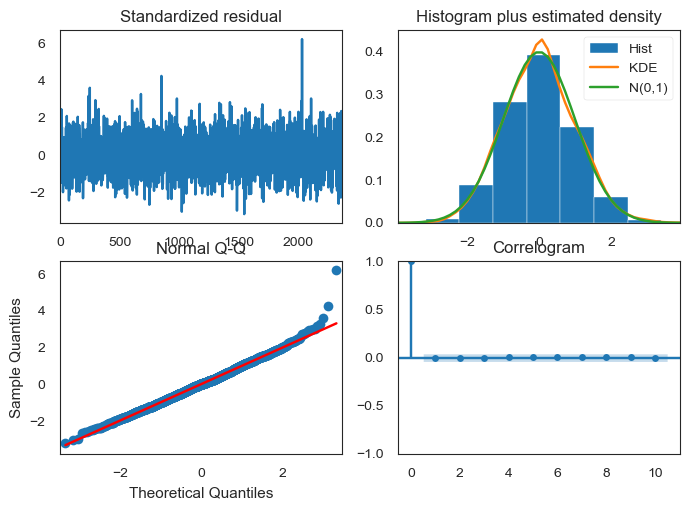

In [9]:
model1.plot_diagnostics();

In [10]:
# model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2367
Model:              SARIMAX(17, 1, 1)   Log Likelihood              -10299.070
Date:                Mon, 01 Apr 2024   AIC                          20664.141
Time:                        21:38:14   BIC                          20854.517
Sample:                             0   HQIC                         20733.450
                               - 2367                                         
Covariance Type:                  opg                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
ROLL_AWAY_estimatedPace                23.6121      3.859      6.118      0.000      16.048      31.176
ROLL_AWAY_DEF_BOXOUTS                 -12.7402      4.829     -2.638      0.008     -22.205      -3.275
ROLL_HOME_FTM                           2.1948      3.442      0.638      0.524      -4.551       8.941
ROLL_HOME_estimatedDefensiveRating     15.1312      3.342      4.527      0.000       8.581      21.682
ROLL_HOME_PTS_FB                       10.5046      3.596      2.921      0.003       3.457      17.552
ROLL_HOME_OPP_PTS_PAINT                 9.1343      3.034      3.011      0.003       3.188      15.081
ROLL_HOME_OPP_TOV_PCT                 -10.8187      3.959     -2.732      0.006     -18.579      -3.059
ROLL_HOME_AST_x                         3.1505      3.019      1.043      0.297      -2.767       9.068
ROLL_HOME_PTS_PAINT                     4.5055      2.843      1.585      0.113      -1.067      10.078
ROLL_AWAY_DFG_PCT                       0.1130      3.242      0.035      0.972      -6.242       6.468
ROLL_AWAY_PTS                           8.5436      4.145      2.061      0.039       0.420      16.667
ROLL_AWAY_PTS_PAINT                    -7.2796      3.676     -1.980      0.048     -14.484      -0.075
ROLL_AWAY_OFF_LOOSE_BALLS_RECOVERED     0.0546      3.408      0.016      0.987      -6.625       6.734
ROLL_AWAY_assistToTurnover              8.5234      3.860      2.208      0.027       0.958      16.089
ar.L1                                  -0.0154      0.022     -0.695      0.487      -0.059       0.028
ar.L2                                  -0.0161      0.023     -0.715      0.475      -0.060       0.028
ar.L3                                  -0.0081      0.021     -0.381      0.703      -0.050       0.033
ar.L4                                  -0.0042      0.022     -0.195      0.845      -0.047       0.038
ar.L5                                  -0.0014      0.023     -0.061      0.951      -0.045       0.043
ar.L6                                   0.0407      0.021      1.922      0.055      -0.001       0.082
ar.L7                                  -0.0117      0.022     -0.532      0.595      -0.055       0.031
ar.L8                                  -0.0298      0.022     -1.357      0.175      -0.073       0.013
ar.L9                                  -0.0173      0.022     -0.783      0.434      -0.061       0.026
ar.L10                                  0.0206      0.022      0.917      0.359      -0.023       0.065
ar.L11                                 -0.0094      0.021     -0.440      0.660      -0.051       0.033
ar.L12                                 -0.0496      0.022     -2.228      0.026      -0.093      -0.006
ar.L13                                 -0.0254      0.021     -1.202      0.229      -0.067       0.016
ar.L14                                  0.0159      0.021      0.748      0.455      -0.026       0.058
ar.L15           

In [11]:
# forecast mean (mu) and CI 
mu_forecast, mu_conf_int = model1.predict(
    n_periods=y_test.shape[0], 
    X=X_test,
    return_conf_int=True
)

# SMAPE
print("Symmetric Mean Absolute Percentage Error:", round(smape(y_test, mu_forecast), 2), "%")
# RMSE
print("Root Mean Squared Error:", round(mean_squared_error(y_test, mu_forecast, squared=False), 2))

Symmetric Mean Absolute Percentage Error: 6.63 %
Root Mean Squared Error: 19.21


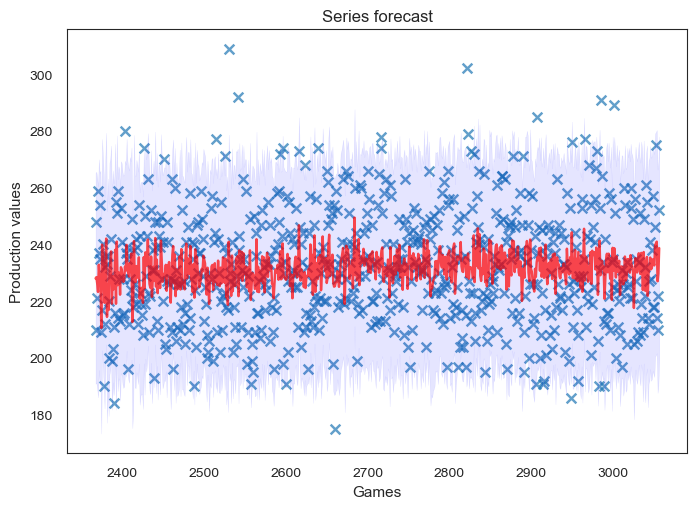

In [13]:
# plot forecast (blue=train, red=forecast)
x_axis = np.arange(pts_sub_fw_features['TOTAL_PTS'].shape[0])
#plt.plot(x_axis[:y_train.shape[0]], y_train, c='blue', alpha=0.7)
plt.plot(x_axis[y_train.shape[0]:], mu_forecast, c='red', alpha=0.7) # forecast
plt.scatter(x_axis[y_train.shape[0]:], y_test, alpha=0.7, marker='x') # test data
plt.fill_between(x_axis[-mu_forecast.shape[0]:], mu_conf_int[:, 0], mu_conf_int[:, 1], 
                 alpha=0.1, color='blue')
plt.title('Series forecast')
plt.xlabel('Games')
plt.ylabel('Production values')
plt.show();

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Models)

In [14]:
# split the data
X_train, X_test, y_train, y_test = pm_train_test_split(
    pm_sub_fw_features.drop('PLUS_MINUS', axis=1),
    pm_sub_fw_features['PLUS_MINUS'], 
    train_size=season_22_ngames+season_23_ngames
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2367, 8) (2367,) (691, 8) (691,)


In [15]:
start_time = time.time()

# fit models
model1 = pm.auto_arima(
    y=y_train, 
    X=X_train,
    start_p=1, max_p=20,
    start_q=1, max_q=5,
    max_d=3,   max_D=2,
    start_P=1, max_P=2,
    start_Q=1, max_Q=2,
    max_order=None,
    seasonal=False,
    stationary=False,
    information_criterion='aic',
    stepwise=True)

arimax_residuals = model1.resid()

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

Total time taken: 4.54 seconds


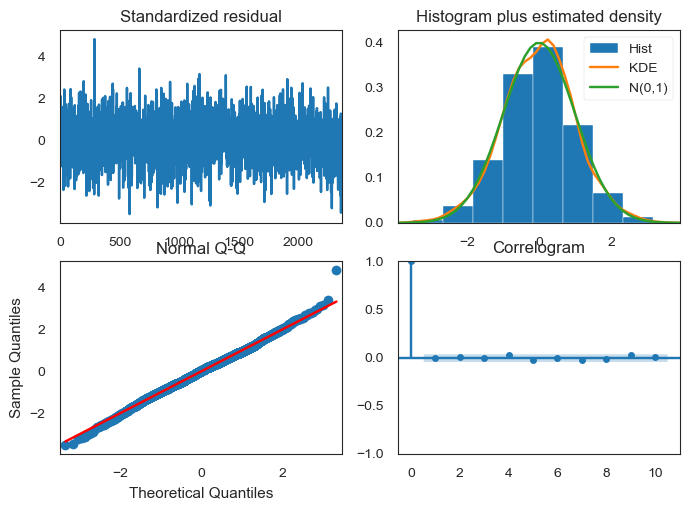

In [16]:
model1.plot_diagnostics();

In [17]:
# model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2367
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -9586.668
Date:                Mon, 01 Apr 2024   AIC                          19195.336
Time:                        21:58:02   BIC                          19258.800
Sample:                             0   HQIC                         19218.441
                               - 2367                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
ROLL_HOME_CFGA              -6.3757      1.712     -3.725      0.000      -9.731      -3.021
ROLL_HOME_SCREEN_ASSISTS     3.3425      2.650      1.261      0.207      -1.852       8.537
ROLLDIFF_AWAY_PTS          -13.2524      2.551     -5.196      0.000     -18.252      -8.253
ROLLDIFF_AWAY_AST           -3.2716      1.994     -1.641      0.101      -7.180       0.637
ROLLDIFF_HOME_PTS           14.3377      1.897      7.557      0.000      10.619      18.057
ROLLDIFF_AWAY_STL           -3.3659      1.702     -1.977      0.048      -6.702      -0.029
ROLL_AWAY_OPP_PTS_PAINT      4.0879      1.952      2.095      0.036       0.263       7.913
ROLL_HOME_CFG_PCT            4.8282      1.825      2.645      0.008       1.250       8.406
ar.L1                        0.8062      0.141      5.704      0.000       0.529       1.083
ma.L1                       -0.8354      0.131     -6.375      0.000      -1.092      -0.579
sigma2                     192.9500      5.198     37.118      0.000     182.762     203.138
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                14.75
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.01
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
# forecast mean (mu) and CI 
mu_forecast, mu_conf_int = model1.predict(
    n_periods=y_test.shape[0], 
    X=X_test,
    return_conf_int=True
)

# SMAPE
print("Symmetric Mean Absolute Percentage Error:", round(smape(y_test, mu_forecast), 2), "%")
# RMSE
print("Root Mean Squared Error:", round(mean_squared_error(y_test, mu_forecast, squared=False), 2))

Symmetric Mean Absolute Percentage Error: 141.37 %
Root Mean Squared Error: 14.38


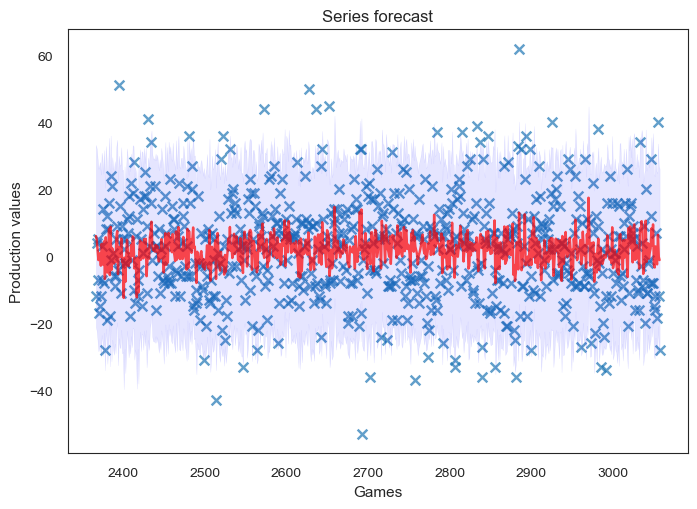

In [20]:
# plot forecast (blue=train, red=forecast)
x_axis = np.arange(pm_sub_fw_features['PLUS_MINUS'].shape[0])
#plt.plot(x_axis[:y_train.shape[0]], y_train, c='blue', alpha=0.7)
plt.plot(x_axis[y_train.shape[0]:], mu_forecast, c='red', alpha=0.7) # forecast
plt.scatter(x_axis[y_train.shape[0]:], y_test, alpha=0.7, marker='x') # test data
plt.fill_between(x_axis[-mu_forecast.shape[0]:], mu_conf_int[:, 0], mu_conf_int[:, 1], 
                 alpha=0.1, color='blue')
plt.title('Series forecast')
plt.xlabel('Games')
plt.ylabel('Production values')
plt.show();